In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input, Conv2DTranspose, Activation, BatchNormalization, Concatenate, MaxPooling2D, Flatten, Dense, Reshape
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar10

from sklearn.decomposition import PCA


**Bài 1:**
Code from scratch hàm transposed convolution


In [ ]:
# Input
Input = tf.constant([[0.0, 1.0], [2.0, 3.0]], dtype=tf.float32)
#Kernel
Kernel = tf.constant([[4.0, 1.0], [2.0, 3.0]], dtype=tf.float32)

In [ ]:
def transposed_conv2d(Input, Kernel, stride=1):
    input_height, input_width = Input.shape
    kernel_height, kernel_width = Kernel.shape
    output_height = (input_height - 1) * stride + kernel_height
    output_width = (input_width - 1) * stride + kernel_width
    output = np.zeros((output_height, output_width))

    for i in range(input_height):
        for j in range(input_width):
            output[i*stride:i * stride + kernel_height, j*stride:j * stride + kernel_width] += Input[i, j] * Kernel

    return output

In [ ]:
transposed_conv2d(Input, Kernel)

array([[ 0.,  4.,  1.],
       [ 8., 16.,  6.],
       [ 4., 12.,  9.]])

**Bài 2:** Cho dataset cifar-10
+ Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)
+ Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu
+ Visualize ảnh ban đầu, ảnh được thêm noise, và ảnh sau khi denoise.


In [ ]:
(train_data, _), (test_data, _) = cifar10.load_data()

# scaling input data
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

def add_noise_and_clip_data(data):
    noise = np.random.normal(loc = 0.0, scale = 0.1, size = data.shape)
    data = data + noise
    data = np.clip(data, 0., 1.)
    return data

train_data_noisy = add_noise_and_clip_data(train_data)
test_data_noisy = add_noise_and_clip_data(test_data)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
def conv_block(x, filters, kernel_size, strides = 2):
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               strides = strides,
               padding = 'same',
               activation = 'relu',
               kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def deconv_block(x, filters, kernel_size):
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        strides = 2,
                        padding = 'same',
                        activation = 'relu',
                        kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    return x

def autoencoder():
    inputs = Input(shape = (32, 32, 3), name = 'inputs')
    conv_block1 = conv_block(inputs, 32, 3)
    conv_block2 = conv_block(conv_block1, 64, 3)
    conv_block3 = conv_block(conv_block2, 128, 3)
    conv_block4 = conv_block(conv_block3, 256, 3)
    conv_block5 = conv_block(conv_block4, 256, 3)
    conv_block6 = conv_block(conv_block5, 512, 3, 1)

    deconv_block1 = deconv_block(conv_block6, 512, 3)
    merge1 = Concatenate()([deconv_block1, conv_block4])
    deconv_block2 = deconv_block(merge1, 256, 3)
    merge2 = Concatenate()([deconv_block2, conv_block3])
    deconv_block3 = deconv_block(merge2, 128, 3)
    merge3 = Concatenate()([deconv_block3, conv_block2])
    deconv_block4 = deconv_block(merge3, 64, 3)
    merge4 = Concatenate()([deconv_block4, conv_block1])
    deconv_block5 = deconv_block(merge4, 32, 3)

    final_deconv = Conv2DTranspose(filters = 3, kernel_size = 3, padding = 'same')(deconv_block5)
    outputs = Activation('sigmoid', name = 'output')(final_deconv)
    return Model(inputs, outputs, name = 'autoencoder')

In [ ]:
model = autoencoder()

def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('best_model.h5', verbose = 1, save_best_only = True, save_weights_only = True)

model.compile(optimizer = "adam", loss = 'mse', metrics=["accuracy"])
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['inputs[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['batch_normalizatio

In [ ]:
# Training model
history = model.fit(train_data_noisy,
                    train_data,
                    validation_data = (test_data_noisy, test_data),
                    epochs = 25,
                    batch_size = 128,
                    shuffle = True)

Epoch 1/25
391/391 [==============================] - 28s 44ms/step - loss: 0.0748 - accuracy: 0.7065 - val_loss: 0.0495 - val_accuracy: 0.5977
Epoch 2/25
391/391 [==============================] - 15s 38ms/step - loss: 0.0032 - accuracy: 0.7507 - val_loss: 0.0124 - val_accuracy: 0.7363
Epoch 3/25
391/391 [==============================] - 16s 42ms/step - loss: 0.0024 - accuracy: 0.7610 - val_loss: 0.0027 - val_accuracy: 0.6947
Epoch 4/25
391/391 [==============================] - 17s 42ms/step - loss: 0.0023 - accuracy: 0.7647 - val_loss: 0.0028 - val_accuracy: 0.7352
Epoch 5/25
391/391 [==============================] - 16s 42ms/step - loss: 0.0023 - accuracy: 0.7666 - val_loss: 0.0026 - val_accuracy: 0.7295
Epoch 6/25
391/391 [==============================] - 16s 42ms/step - loss: 0.0023 - accuracy: 0.7696 - val_loss: 0.0036 - val_accuracy: 0.6476
Epoch 7/25
391/391 [==============================] - 15s 39ms/step - loss: 0.0022 - accuracy: 0.7690 - val_loss: 0.0022 - val_accuracy:

313/313 [==============================] - 2s 6ms/step


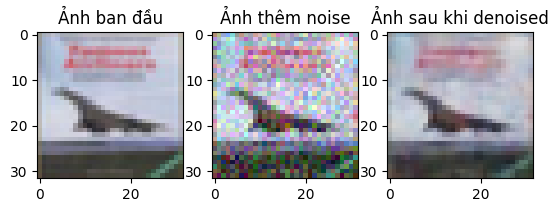

In [ ]:
#model.load_weights('best_model.h5')
test_data_denoised = model.predict(test_data_noisy)

idx = 3
plt.subplot(1,3,1)
plt.imshow(test_data[idx])
plt.title('Ảnh ban đầu')

plt.subplot(1,3,2)
plt.imshow(test_data_noisy[idx])
plt.title('Ảnh thêm noise')

plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('Ảnh sau khi denoised')

plt.show()

**Bài 3:** Cho dataset cifar-10
+ Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.
+ Visualize và so sánh 2 phương pháp


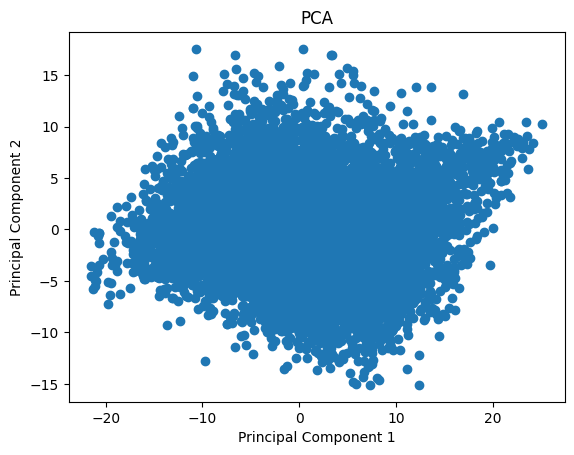

In [ ]:
# PCA
# Reshape and flatten the testing data
test_data_flattened = test_data.reshape(len(test_data), -1)

# Reduce the dimensionality of the image
pca = PCA(n_components = 2)
reduced_image = pca.fit_transform(test_data_flattened)

# Plot the reduced image
plt.scatter(reduced_image[:, 0], reduced_image[:, 1])
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

313/313 [==============================] - 2s 7ms/step


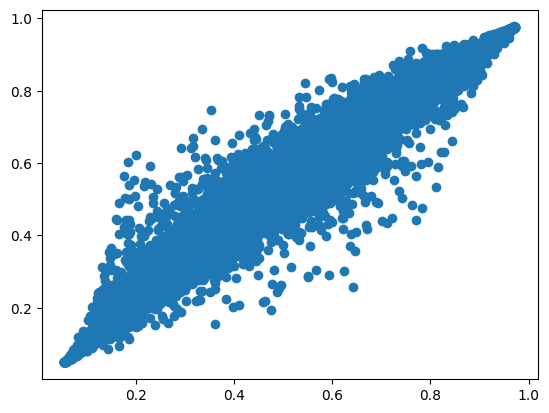

In [ ]:
# Normalize and reshape testing data
test_data = np.reshape(test_data, (len(test_data), 32, 32, 3))

# Encode the testing data
test_encoded = model.predict(test_data)

# Compile the autoencoder
model.compile(optimizer='adam', loss='binary_crossentropy')

# Reshape the encoded data to 2D
test_encoded = test_encoded.reshape(len(test_encoded), -1)

# Plot the encoded image
plt.scatter(test_encoded[:, 0], test_encoded[:, 1])
plt.show()

PCA nhanh hơn convolution AE và có thể được sử dụng cho các dữ liệu không có cấu trúc. Convolution AE có thể học được các thành phần có ý nghĩa hơn PCA và có thể được sử dụng các dữ liệu có cấu trúc.

PCA có thể làm mất thông tin quan trọng, trong khi convolution AE có thể yêu cầu nhiều training data hơn PCA.
